# Analysis of Citibike bike dock stations

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import plotly.express as px
import kaleido

import dash
from dash import html
from dash import dcc
import pydeck as pdk
import dash_deck
from dash.dependencies import Input, Output

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

## Read data
* trips
* stations
* rebalance_pairs
    * transformed station pairs (further in notebook below)
* shapefiles and map tiles

In [ ]:
DATA_DIR = "../data/"
STATIONS_DIR = DATA_DIR + "stations/"
REBALANCE_DIR = DATA_DIR + "rebalance_parquet/"
GEN_DIR = "../app/assets/"
SUBWAY_STOPS_DIR = DATA_DIR + "subway-stops/"

CRS_WEB_MERCATOR = 3857
CRS_OPENSTREETMAP = "WGS-84"

TRIP_YEAR = 2019

In [ ]:
# set mapbox token
MAPBOX_ACCESS_TOKEN = "MAPBOX_ACCESS_TOKEN"
os.environ[MAPBOX_ACCESS_TOKEN] = open("../.mapbox_token").read()

In [ ]:
%%time
trips = helpers.get_trips(TRIP_YEAR, DATA_DIR, convert_dates=True)

CPU times: user 41 s, sys: 32.7 s, total: 1min 13s
Wall time: 1min 14s


In [ ]:
# get top N stations by start of trips
stations_by_tripcount = (
    trips.groupby("startstationid")["bikeid"]
    .count()
    .reset_index()
    .rename(columns={"bikeid": "counttrips"})
    .sort_values(by="counttrips", ascending=False)
)

In [ ]:
# subway lines
subway_lines = gpd.read_file(DATA_DIR + "subwaylines" + helpers.GEOJSON_EXTENSION)
subway_lines = subway_lines.to_crs(CRS_WEB_MERCATOR)

In [ ]:
# subway stops
subway_stops = gpd.read_file(
    SUBWAY_STOPS_DIR + "stops_nyc_subway_nov2020" + helpers.SHAPEFILE_EXTENSION
)
subway_stops = subway_stops.to_crs(CRS_WEB_MERCATOR)

In [ ]:
# read stations
stations = pd.read_csv(STATIONS_DIR + "stations.csv", index_col=0)
stations["stationid"] = stations["stationid"].astype("int64")

In [ ]:
# read boros
# See: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
# How convenient, they use NYC boroughs!
boros = gpd.read_file(gpd.datasets.get_path("nybb"))
# add coordinates for boro label. See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
boros = boros.to_crs(epsg=CRS_WEB_MERCATOR)
boros["boro_coords"] = boros["geometry"].apply(
    lambda x: x.representative_point().coords[:]
)
boros["boro_coords"] = [coords[0] for coords in boros["boro_coords"]]
bronx_staten_indices = [0, 4]  # not in our analysis scope

In [ ]:
# read rebalance pairs, use TRIP_YEAR alone
rebpairs = pd.read_parquet(
    REBALANCE_DIR + "rebalance_pairs" + helpers.PARQUET_EXTENSION, engine="pyarrow"
)
rebpairs = rebpairs.loc[rebpairs.rebal_year == TRIP_YEAR].drop("rebal_year", axis=1)
rebpairs["stationid_from"] = rebpairs["stationid_from"].astype("int")
rebpairs["stationid_to"] = rebpairs["stationid_to"].astype("int")

In [ ]:
# get sorted list of stations by number of bikes rebalanced (rebalanced from and rebalanced to)
stations_by_rebalcount = rebpairs.sort_values(by="rebal_count", ascending=False)
stations_by_rebalcount_from = list(
    stations_by_rebalcount.stationid_from.drop_duplicates()
)
stations_by_rebalcount_to = list(stations_by_rebalcount.stationid_to.drop_duplicates())

In [ ]:
# get total rebalances (from/to) for a stationid
total_rebal_from = (
    stations_by_rebalcount.groupby("stationid_from")["rebal_count"]
    .sum()
    .reset_index()
    .rename(columns={"rebal_count": "total_rebal_count_from"})
    .sort_values(by="total_rebal_count_from", ascending=False)
)
total_rebal_to = (
    stations_by_rebalcount.groupby("stationid_to")["rebal_count"]
    .sum()
    .reset_index()
    .rename(columns={"rebal_count": "total_rebal_count_to"})
    .sort_values(by="total_rebal_count_to", ascending=False)
)
stations_rebal = (
    pd.merge(
        left=total_rebal_from,
        right=total_rebal_to,
        left_on="stationid_from",
        right_on="stationid_to",
        how="outer",
        validate="1:1",
    )
    .drop("stationid_to", axis=1)
    .rename(columns={"stationid_from": "stationid"})
)

## Stations EDA

In [ ]:
def annotate_boros(row):
    """
    Annotate boro names See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
    :param row: the boro row
    :return: None
    """
    plt.annotate(
        text=row["BoroName"],
        xy=row["boro_coords"],
        horizontalalignment="left",
        color="Black",
        size=18,
        bbox={
            "boxstyle": "round",
            "facecolor": "white",
            "alpha": 0.8,
            "pad": 0.1,
            "edgecolor": "none",
        },
    )

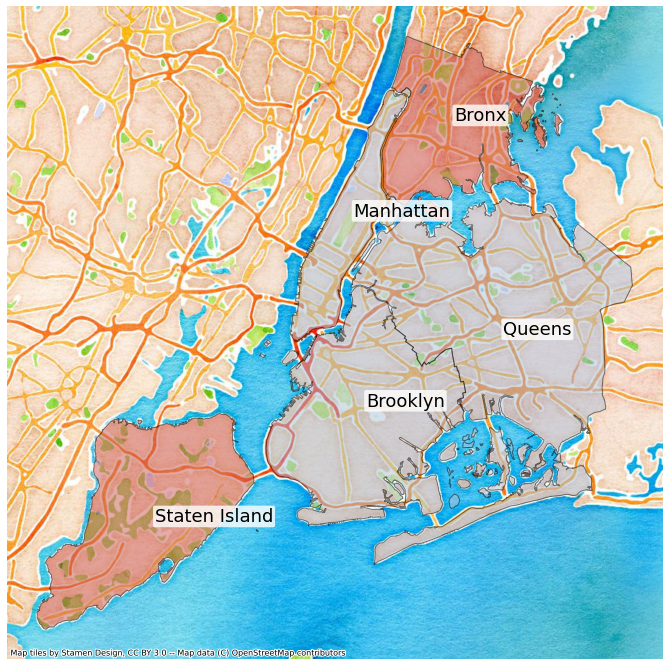

In [ ]:
# plot all 5 boros
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for idx, row in boros.iterrows():
    bronx_staten_indices = [0, 4]  # not in our analysis scope
    boro_color = "indianred" if idx in bronx_staten_indices else "lightsteelblue"
    ax = boros[boros.index == idx].plot(
        alpha=0.5, color=boro_color, edgecolor="k", ax=ax
    )
    annotate_boros(row)
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")

plt.show()

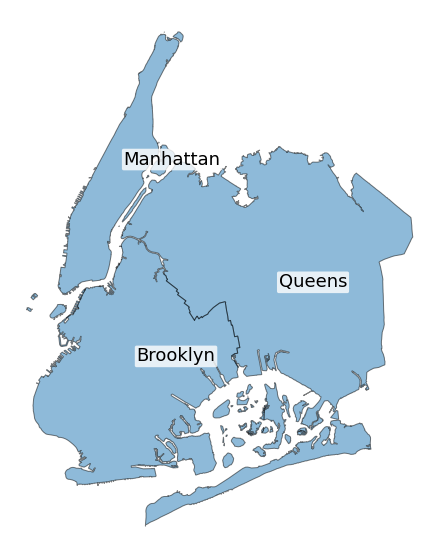

In [ ]:
# drop Staten Island and the Bronx by index
# plot boro shapefiles alone
boros.drop(index=[0, 4], inplace=True)
ax = boros.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros(row)
ax.axis("off")
plt.show()

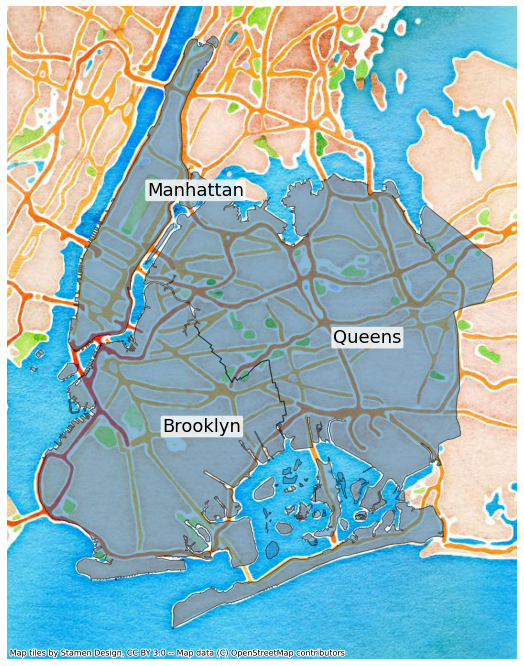

In [ ]:
# plot three boros in our dataset
ax = boros.plot(figsize=(12, 12), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros(row)
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")
plt.show()

In [ ]:
# drop stations with no latitude or longitude, those in 8D and the Bronx
stations = stations.drop(stations[stations["latitude"] == 0.0].index)
stations = stations.drop(stations[stations["longitude"] == 0.0].index)
stations = stations.drop(stations[stations["boro"] == "Ville-Marie"].index)
stations = stations.drop(stations[stations["boro"] == "The Bronx"].index)

In [ ]:
# merge to get tripcount. NOTE: this drops stations not in TRIP_YEAR
stations = pd.merge(
    left=stations_by_tripcount,
    right=stations,
    how="inner",
    left_on="startstationid",
    right_on="stationid",
).drop("startstationid", axis=1)
stations.insert(0, "stationid", stations.pop("stationid"))

In [ ]:
# add rebalance count (from/to) to stations
stations = pd.merge(left=stations, right=stations_rebal, how="left")

In [ ]:
# create geopandas dataframe and set CRS
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude)
)
stations_gdf.crs = CRS_OPENSTREETMAP
stations_gdf = stations_gdf.to_crs(epsg=CRS_WEB_MERCATOR)

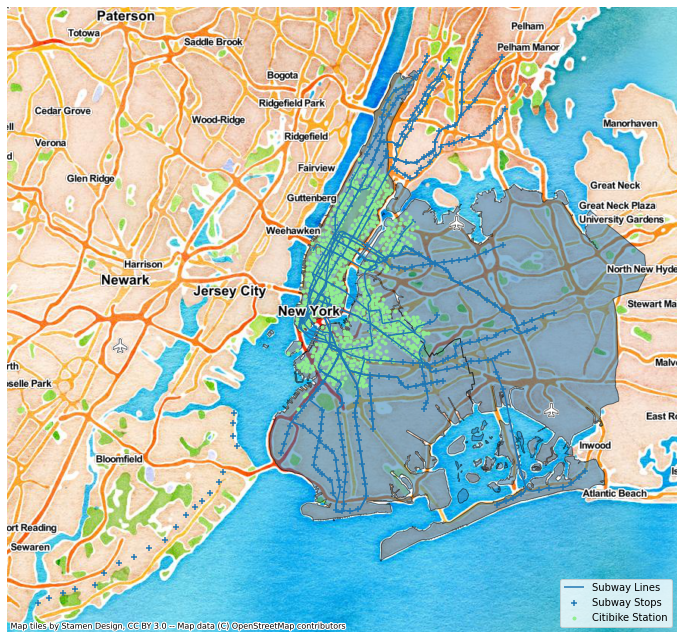

In [ ]:
# plot all stations and subway stops and subway lines
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

ax = boros.plot(alpha=0.5, edgecolor="k", ax=ax)
ax = subway_lines.plot(ax=ax, label="Subway Lines")
ax = subway_stops.plot(ax=ax, label="Subway Stops", marker="+")
ax = stations_gdf.plot(color="lightgreen", ax=ax, label="Citibike Station", marker=".")
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.legend(loc="lower right")
ax.axis("off")

plt.show()

### Plot top stations by trip count, rebalances from, and rebalances to


In [ ]:
def plot_top_stations(
    N=100,
    column_by="counttrips",
    suptitle="SUPTITLE",
    title="SOMETHING",
    legend_label="Number of trips started at station",
    focus_manhattan=False,
    show_subways=True,
):
    """
    Plots the top N stations by column
    :param N:
    :param column_by: one of {"counttrips", "total_rebal_count_from", "total_rebal_count_to"}
    :param title: figure title
    :param legend_label: legend label
    :param focus_manhattan: only draw the boro outline for Manhattan
    :return:
    """
    # plot top stations by tripcount (hint: they're all in Manhattan!)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    # Suptitle too high. See: https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    # plot boros
    boro_colors = ["blue", "steelblue", "royalblue"]
    for idx, row in boros.iterrows():
        if focus_manhattan:
            if idx == 3:
                ax = boros[boros.index == idx].plot(
                    alpha=0.05, color=boro_colors[idx - 1], edgecolor="k", ax=ax
                )
        else:
            ax = boros[boros.index == idx].plot(
                alpha=0.05, color=boro_colors[idx - 1], edgecolor="k", ax=ax
            )
        annotate_boros(row)

    # plot subway lines
    if show_subways:
        ax = subway_lines.plot(ax=ax, label="Subway Lines")
        ax = subway_stops.plot(ax=ax, label="Subway Stops", marker="+")

    # get the top N stations
    stations_gdf_topN = stations_gdf.sort_values(by=column_by, ascending=False).head(N)
    ax = stations_gdf_topN.plot(
        column="counttrips",
        cmap="YlOrRd",
        ax=ax,
        label="Citibike station",
        legend=True,
        legend_kwds={
            "label": legend_label,
            "orientation": "horizontal",
            "pad": 0.01,
            "shrink": 0.5,
            "alpha": 0.5,
        },
    )
    plt.suptitle(suptitle.format(N), fontsize=18)
    plt.title(title)

    cx.add_basemap(ax, source=cx.providers.Stamen.Toner)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
    ax.legend(loc="lower right")
    ax.axis("off")

    plt.show()

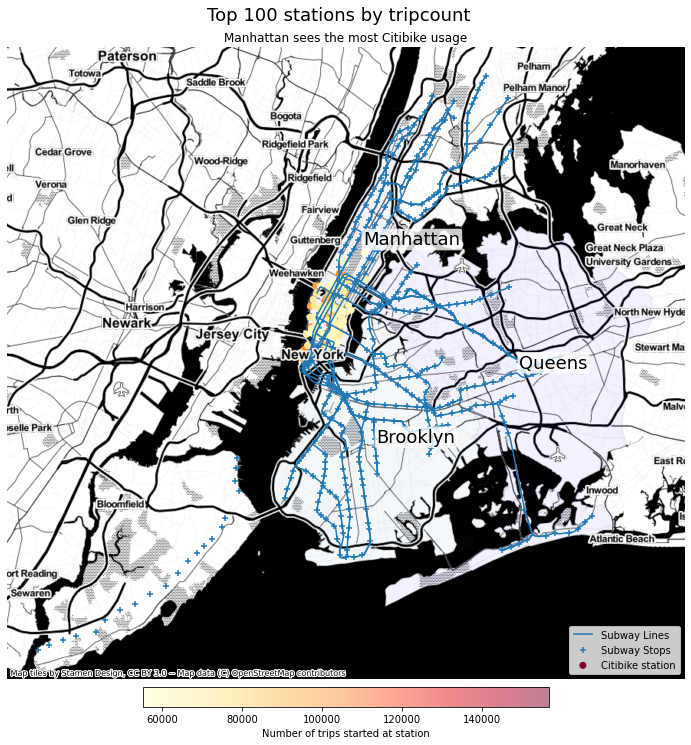

In [ ]:
# plot top stations by tripcount
plot_top_stations(
    N=100,
    column_by="counttrips",
    suptitle="Top {} stations by tripcount",
    title="Manhattan sees the most Citibike usage",
    legend_label="Number of trips started at station",
    focus_manhattan=False,
)

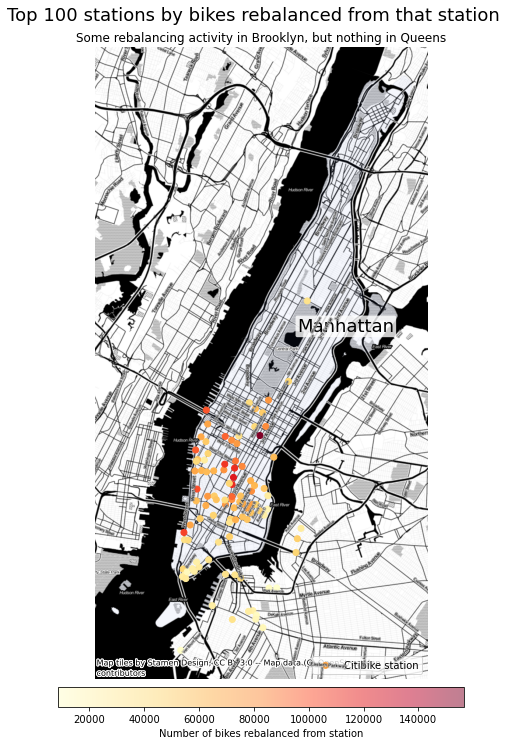

In [ ]:
# plot stations rebalanced from
plot_top_stations(
    N=100,
    column_by="total_rebal_count_from",
    suptitle="Top {} stations by bikes rebalanced from that station",
    title="Some rebalancing activity in Brooklyn, but nothing in Queens",
    legend_label="Number of bikes rebalanced from station",
    focus_manhattan=True,
    show_subways=False,
)

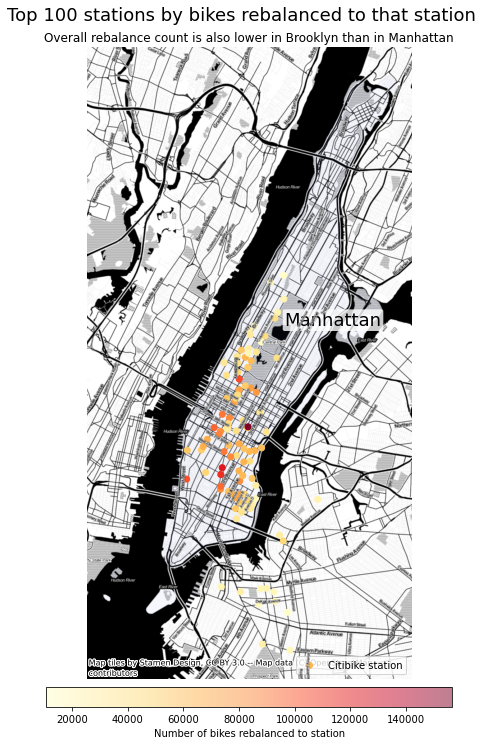

In [ ]:
# plot stations rebalanced to
plot_top_stations(
    N=100,
    column_by="total_rebal_count_to",
    suptitle="Top {} stations by bikes rebalanced to that station",
    title="Overall rebalance count is also lower in Brooklyn than in Manhattan",
    legend_label="Number of bikes rebalanced to station",
    focus_manhattan=True,
    show_subways=False,
)

### Create all stations plot 
Use plotly express scatter mapbox

In [ ]:
def plot_all_stations(mapstyle="stamen-toner"):
    """
    :param mapstyle: one of "stamen-toner" and "stamen-watercolor"
    :return: plotly express Figure
    """
    fig = px.scatter_mapbox(
        stations_gdf,
        lat="latitude",
        lon="longitude",
        hover_name="stationname",
        hover_data={
            "counttrips": True,
            "total_rebal_count_from": True,
            "total_rebal_count_to": True,
            "elevation_ft": True,
            "latitude": False,
            "longitude": False,
        },
        size="counttrips",
        labels={
            "color": "Total rebalances (from/to)",
            "counttrips": "Total Trips",
            "total_rebal_count_from": "Rebalances (from)",
            "total_rebal_count_to": "Rebalances (to)",
            "elevation_ft": "Elevation (ft)",
        },
        color=(stations_gdf.total_rebal_count_from + stations_gdf.total_rebal_count_to),
        # color_continuous_scale=px.colors.sequential.Viridis[::-1],
        zoom=12,
        height=600,
    )
    fig.update_coloraxes(colorbar_orientation="v")
    fig.update_coloraxes(colorbar_title_side="right")
    fig.update_layout(
        mapbox_style=mapstyle, mapbox_accesstoken=os.getenv(MAPBOX_ACCESS_TOKEN)
    )
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_mapboxes(pitch=30)

    return fig

In [ ]:
allstations_toner = plot_all_stations("stamen-toner")
allstations_watercolor = plot_all_stations("stamen-watercolor")

### Create station pairs plots
Setup layers then plot using pydeck/deck.gl

In [ ]:
STATIONS_PAIRS_DIR = DATA_DIR + "stations-pairs/"

In [ ]:
station_pairs = pd.read_csv(
    STATIONS_PAIRS_DIR + "pairs" + helpers.CSV_EXTENSION, index_col=0
)

In [ ]:
# use custom tile layer See: https://github.com/ajduberstein/pydeck_custom_layer
# pydeck does not (yet) have a wrapper for deck.gl's TileLayers
pdk.settings.custom_libraries = [
    {
        "libraryName": "MyTileLayerLibrary",
        "resourceUri": "https://cdn.jsdelivr.net/gh/agressin/pydeck_myTileLayer@master/dist/bundle.js",
    }
]

STAMEN_TONER_DATA_URL = "https://stamen-tiles.a.ssl.fastly.net/toner/{z}/{x}/{y}.png"
STAMEN_WATERCOLOR_DATA_URL = (
    "https://stamen-tiles.a.ssl.fastly.net/watercolor/{z}/{x}/{y}.png"
)

stamen_watercolor_tile_layer = pdk.Layer(
    "MyTileLayer", STAMEN_WATERCOLOR_DATA_URL, visible=True
)
stamen_toner_tile_layer = pdk.Layer("MyTileLayer", STAMEN_TONER_DATA_URL, visible=True)

In [ ]:
# transformation for scatterplot circle size below
stations_gdf["total_rebal_count_from_plus_to"] = (
    stations_gdf.total_rebal_count_from + stations_gdf.total_rebal_count_to
)
stations_gdf["log_rebal"] = np.log(stations_gdf.total_rebal_count_from_plus_to)

In [ ]:
# attempt at creating a colorscale based on total rebalance count for a station
# because pydeck doesn't have good support for functions, this is tricky to get working
# will use just a boolean color split by checking rebalances to > rebalances from

# transform colors to [r,g,b,alpha] for scatter plot circles
# def get_colors(inp, colormap):
#     return colormap(inp) * 255
#
# c = pd.DataFrame(get_colors(stations_gdf.total_rebal_count_from_plus_to, plt.cm.viridis))
# c["colors"] = c.apply(lambda row: [row[0], row[1], row[2], row[3]], axis=1)
# c.drop([0,1,2,3], axis=1, inplace=True)
#
# stations_gdf = pd.concat([stations_gdf, c], axis=1)
#
# count_color_map = stations_gdf[["total_rebal_count_from_plus_to", "colors"]]
# count_color_map = count_color_map.set_index("total_rebal_count_from_plus_to")["colors"]
# count_color_map = count_color_map.to_dict()
#
# color_counter = 0
# def get_scatterplot_color():
#     global color_counter
#     color_counter += 1
#     return count_color_map.get(stations_gdf["total_rebal_count_from_plus_to"][color_counter-1], [0,0,0,0])

In [ ]:
# colors for scatterpoints and arc begin/end
SOURCE_RGB = [51, 51, 255, 150]
TARGET_RGB = [255, 51, 51, 150]

In [ ]:
# Specify a deck.gl ScatterplotLayer

# TODO unused tooltip. pydeck doesn't support more than one tooltip across all layers. could use Altair instead of pydeck
SCATTERPLOT_TOOLTIP_TEXT = {
    "html": "{stationname} (ID: {stationid}) has {total_rebal_count_from_plus_to} bikes rebalanced yearly,<br/> an elevation of {elevation_ft} feet and capacity of {capacity}"
}

scatterplot_layer = pdk.Layer(
    "ScatterplotLayer",
    stations_gdf,
    pickable=False,
    opacity=0.8,
    stroked=False,
    filled=True,
    radius_scale=10,
    radius_min_pixels=1,
    radius_max_pixels=40,
    # line_width_min_pixels=1,
    get_position=["longitude", "latitude"],
    get_radius="log_rebal",
    # get_fill_color=get_scatterplot_color,
    # set color based on rebalance to > rebalance from. TODO, when pydeck supports it, use a function here
    get_fill_color=f"total_rebal_count_to > total_rebal_count_from ? {TARGET_RGB} : {SOURCE_RGB}",
    # get_line_color=[0, 0, 0],
)

In [ ]:
# Specify a deck.gl HexagonLayer (heatmap)
HEATMAP_COLORS = [
    [241, 164, 125],
    [238, 95, 64],
    [215, 27, 51],
    [155, 0, 71],
    [91, 17, 69],
    [39, 17, 47],
]

hexagon_layer = pdk.Layer(
    "HexagonLayer",
    data=stations_gdf,
    get_position=["longitude", "latitude"],
    auto_highlight=True,
    elevation_scale=5,
    pickable=False,
    elevation_range=[0, 100],
    extruded=True,
    coverage=1,
    radius=200,
    color_range=HEATMAP_COLORS,
)

In [ ]:
# transformation for arc width below
station_pairs["width"] = station_pairs.rebal_count / 100  # ~approx 2 to 19

In [ ]:
# Specify a deck.gl ArcLayer
ARC_TOOLTIP_TEXT = {
    "html": "{rebal_count} bikes to be rebalanced <br/>from {stationname_from} to {stationname_to}"
}

arc_layer = pdk.Layer(
    "ArcLayer",
    data=station_pairs,
    get_width="width",
    get_source_position=["longitude_from", "latitude_from"],
    get_target_position=["longitude_to", "latitude_to"],
    get_tilt=10,
    get_source_color=SOURCE_RGB,
    get_target_color=TARGET_RGB,
    pickable=True,
    auto_highlight=True,
)

In [ ]:
# plot station pairs with top rebalance pairs
view_state = pdk.ViewState(
    latitude=station_pairs.latitude_to.mean(),
    longitude=station_pairs.longitude_to.mean(),
    zoom=12,
    bearing=0,
    pitch=30,
)
r_toner_scatter_arc = pdk.Deck(
    [stamen_toner_tile_layer, scatterplot_layer, arc_layer],
    initial_view_state=view_state,
    # tooltip=[SCATTERPLOT_TOOLTIP_TEXT, ARC_TOOLTIP_TEXT], # pydeck supports only one tooltip
    tooltip=ARC_TOOLTIP_TEXT,
    # map_style="dark",
    # map_provider="carto",
    # api_keys=os.getenv(MAPBOX_ACCESS_TOKEN)
)
r_watercolor_scatter_arc = pdk.Deck(
    [stamen_watercolor_tile_layer, scatterplot_layer, arc_layer],
    initial_view_state=view_state,
    tooltip=ARC_TOOLTIP_TEXT,
)
r_toner_heatmap = pdk.Deck(
    [stamen_toner_tile_layer, hexagon_layer],
    initial_view_state=view_state,
)
r_watercolor_heatmap = pdk.Deck(
    [stamen_watercolor_tile_layer, hexagon_layer],
    initial_view_state=view_state,
)

### Save plots

In [ ]:
%%capture
# save to app/assets
if not os.path.exists(GEN_DIR):
    os.mkdir(GEN_DIR)

# save plotly charts
allstations_toner.write_html(GEN_DIR + "allstations" + helpers.HTML_EXTENSION)
allstations_watercolor.write_html(
    GEN_DIR + "allstations-watercolor" + helpers.HTML_EXTENSION
)

# save pydeck charts
r_toner_scatter_arc.to_html(GEN_DIR + "topstations" + helpers.HTML_EXTENSION)
r_watercolor_scatter_arc.to_html(
    GEN_DIR + "topstations-watercolor" + helpers.HTML_EXTENSION
)
r_toner_heatmap.to_html(GEN_DIR + "topstations-heatmap" + helpers.HTML_EXTENSION)
r_watercolor_heatmap.to_html(
    GEN_DIR + "topstations-heatmap-watercolor" + helpers.HTML_EXTENSION
)